In [1]:
## The Baseline Method only use simple gait parameter feature, it only includes 2 dense layers
import scipy.io
import numpy as np
import random

## We delete people's data with low feedback score and remove people who kicked off the sensors during walking'
## So 20 people in total.
person_nums = [1,2,4,5,6,8,9,10,11,12,13,17,19,21,22,25,26,27,28,29]

from feature_emotion import feature_extract, split_data, label_unique_tuples
gts, sensor_nums, walk_nums, trace_nums, people_nums, spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features = feature_extract(person_nums)

walk_nums_all = np.squeeze(walk_nums)
trace_nums_all = np.squeeze(trace_nums)
people_nums_all = np.squeeze(people_nums)

## 0: train, 1: validation 2: test
flag_tr_val_te = split_data(walk_nums_all, trace_nums_all, people_nums_all)

In [2]:
## Data Normalization before training ans testing
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, LSTM
from sklearn.preprocessing import StandardScaler
scalers = []
X_train_normalized = []
X_val_normalized = []
X_test_normalized = []
train_idx = np.where(flag_tr_val_te ==0)[0]
np.random.shuffle(train_idx)
val_idx = np.where(flag_tr_val_te ==1)[0]
test_idx = np.where(flag_tr_val_te ==2)[0]

for i, feature in enumerate([spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features]):
    scaler = StandardScaler()
    if len(feature.shape)==2:
        X_train_i = feature[train_idx,:]
        X_val_i = feature[val_idx,:]
        X_test_i = feature[test_idx,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i)
        X_val_normalized_i = scaler.transform(X_val_i)
        X_test_normalized_i = scaler.transform(X_test_i)
        scalers.append(scaler)
    else:
        X_train_i = feature[train_idx,:,:]
        X_val_i = feature[val_idx,:,:]
        X_test_i = feature[test_idx,:,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i.reshape(X_train_i.shape[0], -1)).reshape(X_train_i.shape)
        X_val_normalized_i = scaler.transform(X_val_i.reshape(X_val_i.shape[0], -1)).reshape(X_val_i.shape)
        X_test_normalized_i = scaler.transform(X_test_i.reshape(X_test_i.shape[0], -1)).reshape(X_test_i.shape)
        scalers.append(scaler)
    X_train_normalized.append(X_train_normalized_i)
    X_val_normalized.append(X_val_normalized_i)
    X_test_normalized.append(X_test_normalized_i)
y_train = gts[train_idx,:]
y_val = gts[val_idx,:]
y_test = gts[test_idx,:]

2023-11-06 23:08:11.199141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def new_label_gen(old_labels):
    new_labels = np.zeros((old_labels.shape[0],))
    
    # Define classes based on conditions
    new_labels[np.logical_and(old_labels[:, 0] <= 5, old_labels[:, 1] < 5)] = 0
    new_labels[np.logical_and(old_labels[:, 0] > 5, old_labels[:, 1] < 5)] = 1
    new_labels[np.logical_and(old_labels[:, 0] <= 5, old_labels[:, 1] >= 5)] = 2
    new_labels[np.logical_and(old_labels[:, 0] > 5, old_labels[:, 1] >= 5)] = 3
    
    # If you need one-hot encoded labels for the classification output
    one_hot_new_labels = np.eye(4)[new_labels.astype(int)]
    return one_hot_new_labels
y_train_class = new_label_gen(y_train)
y_val_class = new_label_gen(y_val)
y_test_class = new_label_gen(y_test)

In [4]:
X_train_normalized_new = []
combined_feature = np.empty((len(X_train_normalized[0]),0))
for feature in X_train_normalized:
    if len(feature.shape) == 3:
        X_train_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_train_normalized_new.append(feature)
X_train_normalized_new.append(combined_feature)

X_val_normalized_new = []
combined_feature = np.empty((len(X_val_normalized[0]),0))
for feature in X_val_normalized:
    if len(feature.shape) == 3:
        X_val_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_val_normalized_new.append(feature)
X_val_normalized_new.append(combined_feature)

X_test_normalized_new = []
combined_feature = np.empty((len(X_test_normalized[0]),0))
for feature in X_test_normalized:
    if len(feature.shape) == 3:
        X_test_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_test_normalized_new.append(feature)
X_test_normalized_new.append(combined_feature)

In [5]:
## Build the baseline model for emotion recognition with dropout layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, SimpleRNN, LSTM, Conv2D, Flatten, MaxPooling2D, GRU, AveragePooling2D, Dropout, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
def individual_model(features_list):
    input_layers = []
    hidden_layers = []
    combined_feature = np.empty((len(features_list[0]),0))
    for i, feature in enumerate(features_list):
        
        if len(feature.shape) == 3:
            input_i = Input(shape=(feature.shape[1], feature.shape[2]))
            input_layers.append(input_i)

            hidden_i = input_i[:,:,:,None]
            hidden_i = Conv2D(32, 3, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((3, 3))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Conv2D(16, 3, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((3, 3))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Conv2D(8, 1, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((2, 2))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Conv2D(4, 1, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((2, 2))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Flatten()(hidden_i)

            hidden_layers.append(hidden_i)
        elif feature.shape[1] <20:
            combined_feature = np.hstack((combined_feature, feature))
            
        else:  # For series features
            input_i = Input(shape=(feature.shape[1],))
            input_layers.append(input_i)
            hidden_i = Lambda(lambda x: x[:, :, None])(input_i)  # Add a new dimension
            hidden_i = LSTM(4)(hidden_i)
            hidden_layers.append(hidden_i)
    input_i = Input(shape=(combined_feature.shape[1],))
    input_layers.append(input_i)
    dense_num = np.max((1, int(combined_feature.shape[1]/2)))
    hidden_i = Dense(dense_num, activation='relu')(input_i)
    hidden_layers.append(hidden_i)
    print(combined_feature.shape)
    concat_layer = concatenate(hidden_layers)
    h = Dropout(0.2)(concat_layer)
    h = Dense(64, activation='relu')(h)
    h = Dense(32, activation='relu')(h)
    output_layer_classification = Dense(4, activation='softmax', name='classification_output')(h)
    model = Model(inputs=input_layers, outputs=output_layer_classification)
    
    # compile the model with categorical_crossentropy loss function
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [6]:
from sklearn.utils import class_weight
# Compute class weights
y_labels = np.argmax(y_train_class, axis=1)
class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes =np.unique(y_labels), y=y_labels)
class_weight_dict = dict(enumerate(class_weights))

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np

class PruningCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_pruning_factor=0.1, final_pruning_factor=0.5, start_epoch=0, end_epoch=None, frequency=1):
        super(PruningCallback, self).__init__()
        self.initial_pruning_factor = initial_pruning_factor
        self.final_pruning_factor = final_pruning_factor
        self.start_epoch = start_epoch
        self.end_epoch = end_epoch if end_epoch is not None else np.inf
        self.frequency = frequency
        self.pruned_weights = {}
        self.layer_importance = {}

    def get_pruning_factor(self, epoch):
        if epoch < self.start_epoch:
            return 0
        if epoch > self.end_epoch:
            return self.final_pruning_factor
        return self.initial_pruning_factor + (self.final_pruning_factor - self.initial_pruning_factor) * (epoch - self.start_epoch) / (self.end_epoch - self.start_epoch)

    def on_train_begin(self, logs=None):
        total_weight_magnitude = 0
        for layer in self.model.layers:
            if hasattr(layer, 'get_weights'):
                weights = layer.get_weights()
                layer_norm = sum(np.linalg.norm(w) for w in weights)
                total_weight_magnitude += layer_norm
                self.layer_importance[layer.name] = layer_norm
    
        # Normalize the layer importance values so they sum up to 1
        for layer_name in self.layer_importance:
            self.layer_importance[layer_name] /= total_weight_magnitude
    # def on_train_begin(self, logs=None):
    #     total_weight_magnitude = sum([np.linalg.norm(layer.get_weights()) for layer in self.model.layers if hasattr(layer, 'get_weights')])
    #     for layer in self.model.layers:
    #         if hasattr(layer, 'get_weights'):
    #             self.layer_importance[layer.name] = np.linalg.norm(layer.get_weights()) / total_weight_magnitude

    def get_layer_pruning_factor(self, layer_name, global_pruning_factor):
        if layer_name in self.layer_importance:
            importance = self.layer_importance[layer_name]
            adjusted_pruning_factor = global_pruning_factor * (1 - importance)
            return min(adjusted_pruning_factor, 1)  # Ensure the pruning factor is not greater than 1
        return global_pruning_factor
    def prune_weights(self, layer, global_pruning_factor):
        
        weights = layer.get_weights()
        layer_name = layer.name
        pruning_factor = self.get_layer_pruning_factor(layer_name, global_pruning_factor)

        if layer_name not in self.pruned_weights:
            self.pruned_weights[layer_name] = [np.zeros_like(w, dtype=bool) for w in weights]
        
        for i in range(len(weights)):
            weight = weights[i]
            # print(weight.shape)
            # print(weight.size)
            if weight.ndim > 1:  # Only prune dense or convolutional layers
                unpruned_weights = np.logical_not(self.pruned_weights[layer_name][i])
                num_unpruned = np.sum(unpruned_weights)
                num_pruning = min(num_unpruned, int(weight.size * pruning_factor) - np.sum(self.pruned_weights[layer_name][i]))
                num_pruning = int(weight.size * pruning_factor) - np.sum(self.pruned_weights[layer_name][i])
                if num_pruning > 0:
                    unpruned_flat_indices = np.flatnonzero(unpruned_weights)
                    abs_unpruned_weights = np.abs(weight[unpruned_weights])
                    pruning_flat_indices = np.argpartition(abs_unpruned_weights, num_pruning)[:num_pruning]
                    
                    indices = np.unravel_index(pruning_flat_indices, weight.shape)
                    self.pruned_weights[layer_name][i][indices] = True

                weights[i] = weights[i]*(~self.pruned_weights[layer_name][i])
                
        layer.set_weights(weights)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch - self.start_epoch) % self.frequency != 0:
            return

        pruning_factor = self.get_pruning_factor(epoch)
        for layer in self.model.layers:
            if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
                self.prune_weights(layer, pruning_factor)
model = individual_model(X_train_normalized)
# model.compile(loss='mean_absolute_error', optimizer='adam')
num_epochs = 100
rates = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
idx = 0
for r in rates:
# Gradually prune weights in dense and convolutional layers from 10% to 50% over the course of training, starting from epoch 0.
    model_name = './checkpoints/Adaptive_prune_model_classify_'+str(idx)+'.h5'
    idx = idx+1
    checkpoint = ModelCheckpoint(model_name, monitor='val_acc', mode='max', save_best_only=True, verbose=1)
    pruning_callback = PruningCallback(initial_pruning_factor=0.01, final_pruning_factor=r, start_epoch=5, end_epoch=50, frequency=1)
    model.fit(x=X_train_normalized_new, y=y_train_class, class_weight=class_weight_dict, epochs=num_epochs, batch_size=1024, validation_data=(X_val_normalized_new, y_val_class), callbacks=[pruning_callback, checkpoint])



2023-11-06 17:03:41.911401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 17:03:41.923679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 17:03:41.923903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-06 17:04:12.951972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 17:04:12.952213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 17:04:12.952385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(29601, 95)
Train on 29601 samples, validate on 3694 samples


2023-11-06 17:04:17.748096: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/lstm_11/lstm_cell_11/bias/v/Assign' id:17277 op device:{requested: '', assigned: ''} def:{{{node training/Adam/lstm_11/lstm_cell_11/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/lstm_11/lstm_cell_11/bias/v, training/Adam/lstm_11/lstm_cell_11/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/100


2023-11-06 17:04:21.674494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-06 17:04:23.797480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-06 17:04:23.831439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


29601/29601 [==============================] - ETA: 0s - loss: 1.3569 - acc: 0.3486

/usr/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_acc improved from -inf to 0.38278, saving model to ./checkpoints/Adaptive_prune_model_classify_0.h5
29601/29601 [==============================] - 28s 957us/sample - loss: 1.3569 - acc: 0.3486 - val_loss: 1.3168 - val_acc: 0.3828
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 1.2964 - acc: 0.4076
Epoch 2: val_acc improved from 0.38278 to 0.40850, saving model to ./checkpoints/Adaptive_prune_model_classify_0.h5
29601/29601 [==============================] - 21s 695us/sample - loss: 1.2964 - acc: 0.4076 - val_loss: 1.2714 - val_acc: 0.4085
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 1.2685 - acc: 0.4140
Epoch 3: val_acc did not improve from 0.40850
29601/29601 [==============================] - 21s 694us/sample - loss: 1.2685 - acc: 0.4140 - val_loss: 1.2583 - val_acc: 0.4047
Epoch 4/100
29601/29601 [==============================] - ETA: 0s - loss: 1.2542 - acc: 0.4096
Epoch 4: val_acc improved from 0.40850 to 0.41

2023-11-06 17:36:54.866984: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29601/29601 [==============================] - ETA: 0s - loss: 0.9942 - acc: 0.5371
Epoch 1: val_acc improved from -inf to 0.46968, saving model to ./checkpoints/Adaptive_prune_model_classify_1.h5
29601/29601 [==============================] - 22s 750us/sample - loss: 0.9942 - acc: 0.5371 - val_loss: 1.1884 - val_acc: 0.4697
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9891 - acc: 0.5376
Epoch 2: val_acc did not improve from 0.46968
29601/29601 [==============================] - 21s 700us/sample - loss: 0.9891 - acc: 0.5376 - val_loss: 1.1877 - val_acc: 0.4675
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9841 - acc: 0.5441
Epoch 3: val_acc did not improve from 0.46968
29601/29601 [==============================] - 19s 648us/sample - loss: 0.9841 - acc: 0.5441 - val_loss: 1.1854 - val_acc: 0.4645
Epoch 4/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9888 - acc: 0.5378
Epoch 4: val_acc improved from 0.

2023-11-06 18:10:00.335626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29601/29601 [==============================] - ETA: 0s - loss: 0.9316 - acc: 0.5681
Epoch 1: val_acc improved from -inf to 0.44099, saving model to ./checkpoints/Adaptive_prune_model_classify_2.h5
29601/29601 [==============================] - 26s 864us/sample - loss: 0.9316 - acc: 0.5681 - val_loss: 1.2383 - val_acc: 0.4410
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9285 - acc: 0.5670
Epoch 2: val_acc improved from 0.44099 to 0.44802, saving model to ./checkpoints/Adaptive_prune_model_classify_2.h5
29601/29601 [==============================] - 21s 697us/sample - loss: 0.9285 - acc: 0.5670 - val_loss: 1.2414 - val_acc: 0.4480
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9275 - acc: 0.5705
Epoch 3: val_acc improved from 0.44802 to 0.45100, saving model to ./checkpoints/Adaptive_prune_model_classify_2.h5
29601/29601 [==============================] - 20s 677us/sample - loss: 0.9275 - acc: 0.5705 - val_loss: 1.2398 - val_a

2023-11-06 18:42:35.157565: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29601/29601 [==============================] - ETA: 0s - loss: 0.9100 - acc: 0.5761
Epoch 1: val_acc improved from -inf to 0.44423, saving model to ./checkpoints/Adaptive_prune_model_classify_3.h5
29601/29601 [==============================] - 24s 797us/sample - loss: 0.9100 - acc: 0.5761 - val_loss: 1.2476 - val_acc: 0.4442
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9138 - acc: 0.5750
Epoch 2: val_acc improved from 0.44423 to 0.45371, saving model to ./checkpoints/Adaptive_prune_model_classify_3.h5
29601/29601 [==============================] - 20s 691us/sample - loss: 0.9138 - acc: 0.5750 - val_loss: 1.2475 - val_acc: 0.4537
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9153 - acc: 0.5719
Epoch 3: val_acc did not improve from 0.45371
29601/29601 [==============================] - 19s 635us/sample - loss: 0.9153 - acc: 0.5719 - val_loss: 1.2436 - val_acc: 0.4518
Epoch 4/100
29601/29601 [==============================] - 

2023-11-06 19:15:02.462982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29601/29601 [==============================] - ETA: 0s - loss: 0.9186 - acc: 0.5738
Epoch 1: val_acc improved from -inf to 0.46048, saving model to ./checkpoints/Adaptive_prune_model_classify_4.h5
29601/29601 [==============================] - 26s 865us/sample - loss: 0.9186 - acc: 0.5738 - val_loss: 1.2303 - val_acc: 0.4605
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9141 - acc: 0.5731
Epoch 2: val_acc did not improve from 0.46048
29601/29601 [==============================] - 20s 668us/sample - loss: 0.9141 - acc: 0.5731 - val_loss: 1.2442 - val_acc: 0.4521
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9132 - acc: 0.5725
Epoch 3: val_acc did not improve from 0.46048
29601/29601 [==============================] - 20s 689us/sample - loss: 0.9132 - acc: 0.5725 - val_loss: 1.2411 - val_acc: 0.4526
Epoch 4/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9120 - acc: 0.5760
Epoch 4: val_acc did not improve 

2023-11-06 19:48:06.388056: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29601/29601 [==============================] - ETA: 0s - loss: 0.9278 - acc: 0.5647
Epoch 1: val_acc improved from -inf to 0.45560, saving model to ./checkpoints/Adaptive_prune_model_classify_5.h5
29601/29601 [==============================] - 25s 845us/sample - loss: 0.9278 - acc: 0.5647 - val_loss: 1.2412 - val_acc: 0.4556
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9234 - acc: 0.5698
Epoch 2: val_acc did not improve from 0.45560
29601/29601 [==============================] - 19s 634us/sample - loss: 0.9234 - acc: 0.5698 - val_loss: 1.2380 - val_acc: 0.4548
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9151 - acc: 0.5758
Epoch 3: val_acc improved from 0.45560 to 0.45642, saving model to ./checkpoints/Adaptive_prune_model_classify_5.h5
29601/29601 [==============================] - 19s 646us/sample - loss: 0.9151 - acc: 0.5758 - val_loss: 1.2433 - val_acc: 0.4564
Epoch 4/100
29601/29601 [==============================] - 

2023-11-06 20:19:47.763326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29601/29601 [==============================] - ETA: 0s - loss: 0.9356 - acc: 0.5634
Epoch 1: val_acc improved from -inf to 0.46021, saving model to ./checkpoints/Adaptive_prune_model_classify_6.h5
29601/29601 [==============================] - 26s 880us/sample - loss: 0.9356 - acc: 0.5634 - val_loss: 1.2217 - val_acc: 0.4602
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9365 - acc: 0.5669
Epoch 2: val_acc did not improve from 0.46021
29601/29601 [==============================] - 20s 691us/sample - loss: 0.9365 - acc: 0.5669 - val_loss: 1.2239 - val_acc: 0.4543
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9297 - acc: 0.5655
Epoch 3: val_acc improved from 0.46021 to 0.46156, saving model to ./checkpoints/Adaptive_prune_model_classify_6.h5
29601/29601 [==============================] - 18s 604us/sample - loss: 0.9297 - acc: 0.5655 - val_loss: 1.2227 - val_acc: 0.4616
Epoch 4/100
29601/29601 [==============================] - 

2023-11-06 20:52:00.133021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29601/29601 [==============================] - ETA: 0s - loss: 0.9586 - acc: 0.5567
Epoch 1: val_acc improved from -inf to 0.44667, saving model to ./checkpoints/Adaptive_prune_model_classify_7.h5
29601/29601 [==============================] - 26s 888us/sample - loss: 0.9586 - acc: 0.5567 - val_loss: 1.2088 - val_acc: 0.4467
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9510 - acc: 0.5578
Epoch 2: val_acc improved from 0.44667 to 0.44857, saving model to ./checkpoints/Adaptive_prune_model_classify_7.h5
29601/29601 [==============================] - 20s 687us/sample - loss: 0.9510 - acc: 0.5578 - val_loss: 1.2205 - val_acc: 0.4486
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9489 - acc: 0.5579
Epoch 3: val_acc improved from 0.44857 to 0.45642, saving model to ./checkpoints/Adaptive_prune_model_classify_7.h5
29601/29601 [==============================] - 19s 630us/sample - loss: 0.9489 - acc: 0.5579 - val_loss: 1.2150 - val_a

2023-11-06 21:23:37.535677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29601/29601 [==============================] - ETA: 0s - loss: 0.9504 - acc: 0.5574
Epoch 1: val_acc improved from -inf to 0.45966, saving model to ./checkpoints/Adaptive_prune_model_classify_8.h5
29601/29601 [==============================] - 27s 913us/sample - loss: 0.9504 - acc: 0.5574 - val_loss: 1.2270 - val_acc: 0.4597
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9504 - acc: 0.5580
Epoch 2: val_acc improved from 0.45966 to 0.46318, saving model to ./checkpoints/Adaptive_prune_model_classify_8.h5
29601/29601 [==============================] - 21s 694us/sample - loss: 0.9504 - acc: 0.5580 - val_loss: 1.2088 - val_acc: 0.4632
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9509 - acc: 0.5611
Epoch 3: val_acc did not improve from 0.46318
29601/29601 [==============================] - 20s 689us/sample - loss: 0.9509 - acc: 0.5611 - val_loss: 1.2301 - val_acc: 0.4499
Epoch 4/100
29601/29601 [==============================] - 

2023-11-06 21:55:25.530706: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29601/29601 [==============================] - ETA: 0s - loss: 0.9826 - acc: 0.5476
Epoch 1: val_acc improved from -inf to 0.45723, saving model to ./checkpoints/Adaptive_prune_model_classify_9.h5
29601/29601 [==============================] - 25s 844us/sample - loss: 0.9826 - acc: 0.5476 - val_loss: 1.2206 - val_acc: 0.4572
Epoch 2/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9774 - acc: 0.5473
Epoch 2: val_acc improved from 0.45723 to 0.46291, saving model to ./checkpoints/Adaptive_prune_model_classify_9.h5
29601/29601 [==============================] - 20s 660us/sample - loss: 0.9774 - acc: 0.5473 - val_loss: 1.2081 - val_acc: 0.4629
Epoch 3/100
29601/29601 [==============================] - ETA: 0s - loss: 0.9690 - acc: 0.5515
Epoch 3: val_acc improved from 0.46291 to 0.46616, saving model to ./checkpoints/Adaptive_prune_model_classify_9.h5
29601/29601 [==============================] - 20s 683us/sample - loss: 0.9690 - acc: 0.5515 - val_loss: 1.2150 - val_a

In [7]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_0.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-11-06 23:09:15.162369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 23:09:15.162589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 23:09:15.162770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Accuracy: 54.05%
Confusion Matrix:
[[31  8  5 15]
 [26 61 20  9]
 [ 6 14 47  8]
 [12  9 10 28]]


In [8]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.540453074433657

In [9]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_1.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:10:05.741546: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_13_1/lstm_cell_50/recurrent_kernel/Assign' id:11747 op device:{requested: '', assigned: ''} def:{{{node lstm_13_1/lstm_cell_50/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_13_1/lstm_cell_50/recurrent_kernel, lstm_13_1/lstm_cell_50/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:10:06.944193: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_18_1/lstm_cell_55/recurrent_kernel/v/Assign' id:17235 op device:{requested: '', assigned: ''} def:{{{node lstm_18_1/lstm_cell_55/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_18_1/lstm_cell_55/re

Accuracy: 53.07%
Confusion Matrix:
[[37  5  5 12]
 [37 47 21 11]
 [ 9  9 54  3]
 [15  5 13 26]]


In [10]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5307443365695793

In [11]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_2.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:10:30.707163: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_17_2/lstm_cell_91/recurrent_kernel/Assign' id:21678 op device:{requested: '', assigned: ''} def:{{{node lstm_17_2/lstm_cell_91/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_17_2/lstm_cell_91/recurrent_kernel, lstm_17_2/lstm_cell_91/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:10:32.216884: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_31_2/lstm_cell_105/recurrent_kernel/v/Assign' id:26721 op device:{requested: '', assigned: ''} def:{{{node lstm_31_2/lstm_cell_105/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_31_2/lstm_cell_105

Accuracy: 54.37%
Confusion Matrix:
[[37 12  5  5]
 [24 56 24 12]
 [ 9 13 50  3]
 [13  9 12 25]]


In [12]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5436893203883495

In [13]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_3.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:10:57.114045: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_10_3/lstm_cell_121/kernel/Assign' id:29829 op device:{requested: '', assigned: ''} def:{{{node lstm_10_3/lstm_cell_121/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_10_3/lstm_cell_121/kernel, lstm_10_3/lstm_cell_121/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:10:58.985319: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1_3/bias/v/Assign' id:36116 op device:{requested: '', assigned: ''} def:{{{node dense_1_3/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1_3/bias/v, dense_1_3/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was

Accuracy: 55.34%
Confusion Matrix:
[[34 11  4 10]
 [22 57 25 12]
 [10 11 51  3]
 [13  7 10 29]]


In [14]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5533980582524272

In [15]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_4.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:11:24.384610: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_31_4/lstm_cell_179/recurrent_kernel/Assign' id:42502 op device:{requested: '', assigned: ''} def:{{{node lstm_31_4/lstm_cell_179/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_31_4/lstm_cell_179/recurrent_kernel, lstm_31_4/lstm_cell_179/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:11:26.636781: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_1_4/bias/m/Assign' id:44165 op device:{requested: '', assigned: ''} def:{{{node conv2d_1_4/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_1_4/bias/m, conv2d_1_4/bias/m/Initializer/zeros)}}' was change

Accuracy: 55.99%
Confusion Matrix:
[[37  9  3 10]
 [25 57 24 10]
 [ 5 11 51  8]
 [12  8 11 28]]


In [16]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5598705501618123

In [17]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_5.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:11:52.628115: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_19_5/lstm_cell_204/recurrent_kernel/Assign' id:49871 op device:{requested: '', assigned: ''} def:{{{node lstm_19_5/lstm_cell_204/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_19_5/lstm_cell_204/recurrent_kernel, lstm_19_5/lstm_cell_204/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:11:55.280591: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_7_5/lstm_cell_192/bias/v/Assign' id:54239 op device:{requested: '', assigned: ''} def:{{{node lstm_7_5/lstm_cell_192/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_7_5/lstm_cell_192/bias/v, lstm_7_5/lstm_

Accuracy: 52.75%
Confusion Matrix:
[[36 10  3 10]
 [27 51 30  8]
 [ 6 15 50  4]
 [14  7 12 26]]


In [18]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5275080906148867

In [27]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_6.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:17:17.518381: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_1_10/lstm_cell_371/bias/Assign' id:93455 op device:{requested: '', assigned: ''} def:{{{node lstm_1_10/lstm_cell_371/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_1_10/lstm_cell_371/bias, lstm_1_10/lstm_cell_371/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:17:22.226433: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_35_10/lstm_cell_405/bias/v/Assign' id:101114 op device:{requested: '', assigned: ''} def:{{{node lstm_35_10/lstm_cell_405/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_35_10/lstm_cell_405/bias/v, lstm_35_10/lstm_cell_405/bias/v/Initializer/zeros)}}' 

Accuracy: 56.63%
Confusion Matrix:
[[44  7  4  4]
 [33 55 21  7]
 [10 14 46  5]
 [15  5  9 30]]


In [28]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5663430420711975

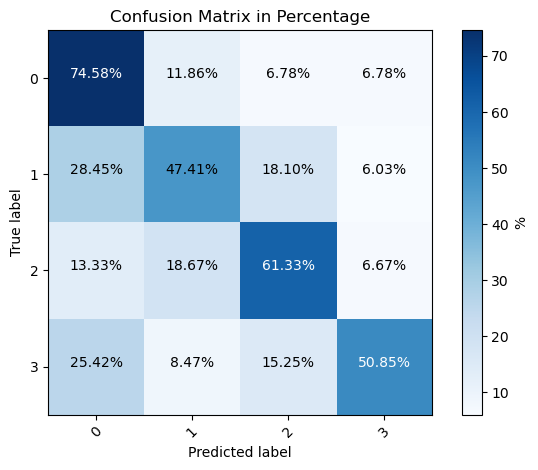

In [29]:
import matplotlib.pyplot as plt
# Normalize the matrix to get percentages
matrix = cm
normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
percentage_matrix = normalized_matrix * 100

# Plot the matrix
plt.imshow(percentage_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix in Percentage')
plt.colorbar(label='%')
tick_marks = np.arange(4)  # Adjust if you have a different number of classes
plt.xticks(tick_marks, range(4), rotation=45)
plt.yticks(tick_marks, range(4))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Display percentages on the matrix
for i in range(percentage_matrix.shape[0]):
    for j in range(percentage_matrix.shape[1]):
        plt.text(j, i, format(percentage_matrix[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if percentage_matrix[i, j] > 50 else "black")

plt.tight_layout()
plt.show()

In [31]:
f1_score(gt_trace, pred_trace, average=None)

array([0.54658385, 0.55837563, 0.59354839, 0.57142857])

In [21]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_7.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:12:54.829175: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_9_7/lstm_cell_268/bias/Assign' id:66862 op device:{requested: '', assigned: ''} def:{{{node lstm_9_7/lstm_cell_268/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_9_7/lstm_cell_268/bias, lstm_9_7/lstm_cell_268/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:12:58.289896: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_10/kernel/v/Assign' id:72664 op device:{requested: '', assigned: ''} def:{{{node conv2d_10/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_10/kernel/v, conv2d_10/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a se

Accuracy: 55.02%
Confusion Matrix:
[[33  7  6 13]
 [33 50 19 14]
 [ 8  8 54  5]
 [ 9  7 10 33]]


In [22]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5501618122977346

In [23]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_8.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:13:26.214147: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_23_8/lstm_cell_319/bias/Assign' id:78395 op device:{requested: '', assigned: ''} def:{{{node lstm_23_8/lstm_cell_319/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_23_8/lstm_cell_319/bias, lstm_23_8/lstm_cell_319/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:13:30.061974: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_24_8/lstm_cell_320/recurrent_kernel/m/Assign' id:81719 op device:{requested: '', assigned: ''} def:{{{node lstm_24_8/lstm_cell_320/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_24_8/lstm_cell_320/recurrent_kernel/m, lstm_24_8/lstm_cell_32

Accuracy: 54.37%
Confusion Matrix:
[[26 10  4 19]
 [18 58 20 20]
 [ 4 12 47 12]
 [ 7 10  5 37]]


In [24]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5436893203883495

In [25]:
## Evaluation on test set:
import tensorflow as tf
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_classify_9.h5")
y_pred_class = model.predict(X_test_normalized_new)
from collections import Counter

def find_mode(nums):
    count = Counter(nums)
    return count.most_common(1)[0][0]

## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 1))
gt_trace = np.empty((0, 1))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred_class[trace_idx,:]
  pred_class = np.argmax(y_pred_trace, axis=1)
  pred_trace = np.vstack((pred_trace, find_mode(pred_class)))
  gt_t = y_test_class[trace_idx[0],:]
  gt_t =np.argmax(gt_t)
  gt_trace = np.vstack((gt_trace, gt_t))

from sklearn.metrics import accuracy_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(gt_trace, pred_trace)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(gt_trace, pred_trace)
print('Confusion Matrix:')
print(cm)

2023-11-06 23:13:59.218914: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_34_9/lstm_cell_367/bias/Assign' id:89446 op device:{requested: '', assigned: ''} def:{{{node lstm_34_9/lstm_cell_367/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_34_9/lstm_cell_367/bias, lstm_34_9/lstm_cell_367/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-06 23:14:03.522264: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_11/kernel/v/Assign' id:91845 op device:{requested: '', assigned: ''} def:{{{node dense_11/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_11/kernel/v, dense_11/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a se

Accuracy: 53.40%
Confusion Matrix:
[[38  5  6 10]
 [37 46 19 14]
 [ 8 12 50  5]
 [ 8  4 16 31]]


In [26]:
from sklearn.metrics import f1_score
f1_score(gt_trace, pred_trace, average='micro')

0.5339805825242718